### Analyzing NYC High School Data
This project is about ranking New York City High Schools by their SAT average score and analyzing which variables can contribute to some schools doing better than others. 

##### The datasets used were:

ap_2010.csv: The Advanced Placement exam results for each high school.

class_size.csv: The class size for each school.

demographics.csv: The different demographic groups attending each school.

graduation.csv: Percentage of students graduating from each school.

hs_directory.csv: School attendance.

sat_results.csv: SAT scores for each high school in New York City.

Additionally, two survey datasets, survey_all.txt and survey_d75.txt were used to assemble the school evaluations done by teachers, parents and students.


### Setting up the data

### Read in the data

In [48]:
import pandas as pd
import numpy
import re
data_files = [
    "ap_2010.csv",
    "class_size.csv",
    "demographics.csv",
    "graduation.csv",
    "hs_directory.csv",
    "sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

### Read in the surveys

In [49]:
all_survey = pd.read_csv("schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

### Add DBN columns

In [50]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

### Convert columns to numeric

In [51]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

### Condense datasets

In [52]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

### Convert AP scores to numeric

In [53]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

### Combine the datasets

In [54]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

### Add a school district column for mapping

In [55]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

### Finding correlations within the data

### Find correlations

In [56]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score         0.986820
SAT Math Avg. Score                     0.972643
SAT Writing Avg. Score                  0.987771
sat_score                               1.000000
AP Test Takers                          0.523140
Total Exams Taken                       0.514333
Number of Exams with scores 3 4 or 5    0.463245
Total Cohort                            0.325144
CSD                                     0.042948
NUMBER OF STUDENTS / SEATS FILLED       0.394626
NUMBER OF SECTIONS                      0.362673
AVERAGE CLASS SIZE                      0.381014
SIZE OF SMALLEST CLASS                  0.249949
SIZE OF LARGEST CLASS                   0.314434
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
fl_percent                                   NaN
frl_percent                            -0.722225
total_enrollment                        0.367857
ell_num                                -0.153778
ell_percent         

### Plotting survey correlations

In [57]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

In [58]:
#setting up a matplotlib to work in jupytre
%matplotlib inline

#surveying the final output of my combined dataframe
combined.head(2)

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score,sat_score,SchoolName,AP Test Takers,Total Exams Taken,...,priority05,priority06,priority07,priority08,priority09,priority10,Location 1,lat,lon,school_dist
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355.0,404.0,363.0,1122.0,0,129.028846,197.038462,...,Then to New York City residents,0,0,0,0,0,"220 Henry Street\nNew York, NY 10002\n(40.7137...",40.713764,-73.985260,01
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383.0,423.0,366.0,1172.0,UNIVERSITY NEIGHBORHOOD H.S.,39.000000,49.000000,...,0,0,0,0,0,0,"200 Monroe Street\nNew York, NY 10002\n(40.712...",40.712332,-73.984797,01


In [59]:
#having a view on what the survey_fields look likem which are various  survey input made by parents, teachers and students
print(survey_fields)

['rr_s', 'rr_t', 'rr_p', 'N_s', 'N_t', 'N_p', 'saf_p_11', 'com_p_11', 'eng_p_11', 'aca_p_11', 'saf_t_11', 'com_t_11', 'eng_t_11', 'aca_t_11', 'saf_s_11', 'com_s_11', 'eng_s_11', 'aca_s_11', 'saf_tot_11', 'com_tot_11', 'eng_tot_11', 'aca_tot_11']


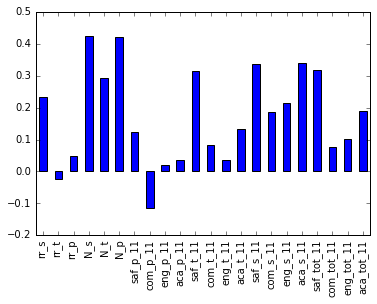

In [60]:
#making a bar correlation between the survey_fields and the sat_score
combined.corr()['sat_score'][survey_fields].plot.bar(color='Blue')

From the above bar chart which is a correlations between the survey_fields and sat_score in the combined data. 

It was quite interesting to see that some of our columns in the survey_fields have storng correlation than the others. we will go into the different columns to understand why:

NB strong correrations are marked by values ranging or close to(-1 and 1) respectively.

a) N_s correlation with correlation point of about 0.43 corresponds to number of student that responded. 

b) N_t correlation with correlation point of about 0.3 corresponds to number of teachers that responded.

c) N_p correlation with correlation point of about 0.43 corresponds to number of parents that responded.

it is fascinating to note that both parents and students have equal correlation point value, it could mean that each student that corresponded was as a result of parents follow up or vice versa or students who filled the forms are those who are likely to do well in school.

Also, students and teachers percieved safety (saf_t_11 and saf_s_11) correlate with sat_score. This make sense, as it's hard to teach or learn in an unsafe environment.

we could also see that aca_s_11, which indicates how the student perceives academic standards, correlates with sat_score, but this is not true for aca_t_11, how teachers perceive academic standards, or aca_p_11, how parents perceive academic standards.


### Exploring safety and SAT scores

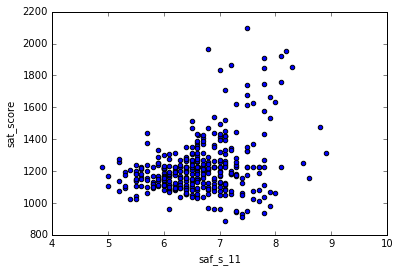

In [61]:
combined.plot.scatter('saf_s_11', 'sat_score')

There is a correlation brtween safety of students and the sat_score, though it is not that strong. from the plot, we could see that few schools who had high sat_scores has a safety rating of more than scale 7. there seems to be clusttering of schools within point 6-7 scales safety value. But they all have sat_scores of up to 1200. 

We could say same for teachers. few conclusion from this is the environment of the school district points has an effect on the sat_score

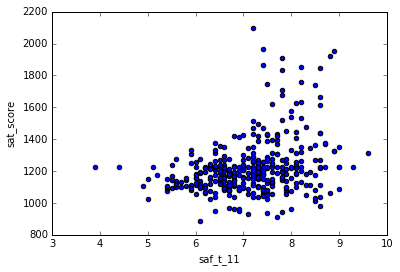

In [62]:
combined.plot.scatter('saf_t_11', 'sat_score')

In [63]:
#looking out on how are schools are distributed in a particular district
print(combined['school_dist'])

0      01
1      01
2      01
3      01
4      01
5      01
6      02
7      02
8      02
9      02
10     02
11     02
12     02
13     02
14     02
15     02
16     02
17     02
18     02
19     02
20     02
21     02
22     02
23     02
24     02
25     02
26     02
27     02
28     02
29     02
       ..
333    29
334    29
335    29
336    29
337    29
338    30
339    30
340    30
341    30
342    30
343    30
344    30
345    30
346    30
347    31
348    31
349    31
350    31
351    31
352    31
353    31
354    31
355    31
356    31
357    32
358    32
359    32
360    32
361    32
362    32
Name: school_dist, Length: 363, dtype: object


### Mapping using basemap acorss districts the safety and SAT Scores 

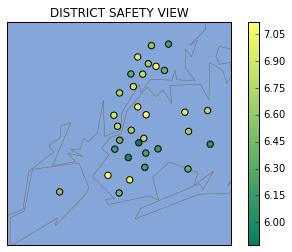

In [64]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

#computing the average school district
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(projection='merc', 
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
            resolution='i'
           )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

#let us now pass in our created or extracted longitude value to the basemap
#we will first convert the created lat and lon values to list value

longtitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longtitudes, latitudes, c=districts['saf_s_11'], s=40, zorder=2, latlon=True, cmap='summer')
plt.title("DISTRICT SAFETY VIEW")
plt.colorbar()
plt.show()

checking out the corresponding points with the district locations, we could notice that Bronx and Queens districs seems to have high safety students points, while staten island has little safety point and Brooklyn seems to have the least safety students points

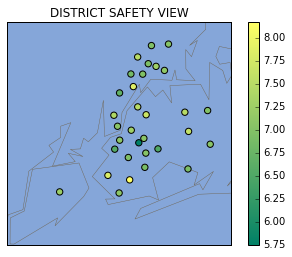

In [65]:
#let us check out for teachers 
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

#computing the average school district
districts = combined.groupby('school_dist').agg(numpy.mean)
districts.reset_index(inplace=True)

m = Basemap(projection='merc', 
            llcrnrlat=40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
            resolution='i'
           )
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)

#let us now pass in our created or extracted longitude value to the basemap
#we will first convert the created lat and lon values to list value

longtitudes = districts['lon'].tolist()
latitudes = districts['lat'].tolist()

m.scatter(longtitudes, latitudes, c=districts['saf_t_11'], s=40, zorder=2, latlon=True, cmap='summer')
plt.title('DISTRICT SAFETY VIEW')
plt.colorbar()
plt.show()

we could notice similar mapping plot as regards the teachers.

### Now let us explore race and SAT scores

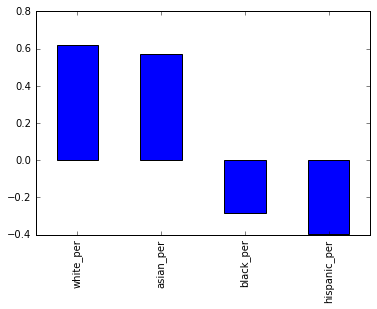

In [66]:
#let us work on race and sat_Scores

race_field = ['white_per', 'asian_per', 'black_per', 'hispanic_per']
race_field_corr = combined.corr()['sat_score'][race_field]
race_field_corr.plot.bar(color='blue')
plt.show()


it could be seen that a higher percentage of white_per and asian_per has a high positve correlation value which is at about 0.6, while a higher negative correlation value is being made by black_per and hispanic_per students. could it be as a result of poor funding from such schools?

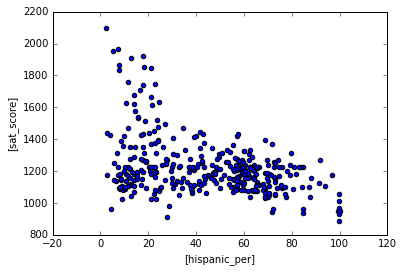

In [67]:
#let us look at the hispanic and sat_score using scatter plots

combined.plot.scatter(['hispanic_per'],['sat_score'])

we coould see that majority of the percentage of schools with hispanic got sat_score of 1000-1200, where as few reached the point of up to 2000

In [68]:
# Now, let us see the schools with percentage of hispanic students
print(combined['hispanic_per'])

0      53.8
1      45.9
2      55.4
3      56.9
4      14.2
5      18.2
6      59.2
7      47.6
8      60.6
9      66.1
10     42.0
11     59.2
12     73.2
13     50.6
14     55.7
15     48.4
16     45.1
17     43.0
18     58.7
19     57.2
20     32.8
21     57.2
22     23.7
23     14.6
24     14.0
25     39.9
26     11.6
27     21.7
28     74.8
29     49.7
       ... 
333    14.1
334    10.4
335     7.5
336    11.9
337     8.5
338    40.4
339    53.5
340    48.8
341    62.7
342    27.2
343    56.6
344    43.5
345    34.7
346    24.3
347    17.9
348    17.6
349    16.9
350    27.3
351    37.6
352    31.9
353     9.9
354    24.1
355    33.2
356     5.3
357    77.1
358    88.1
359    68.7
360    70.4
361    79.5
362    77.3
Name: hispanic_per, Length: 363, dtype: float64


In [69]:
# Now, let us see the schools with a hspanic of more than 95% with the school name
hispanic_school = combined[combined['hispanic_per'] > 95]['SCHOOL NAME']
print(hispanic_school)


44                         MANHATTAN BRIDGES HIGH SCHOOL
82      WASHINGTON HEIGHTS EXPEDITIONARY LEARNING SCHOOL
89     GREGORIO LUPERON HIGH SCHOOL FOR SCIENCE AND M...
125                  ACADEMY FOR LANGUAGE AND TECHNOLOGY
141                INTERNATIONAL SCHOOL FOR LIBERAL ARTS
176     PAN AMERICAN INTERNATIONAL HIGH SCHOOL AT MONROE
253                            MULTICULTURAL HIGH SCHOOL
286               PAN AMERICAN INTERNATIONAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


From the details of each schools with hispanic percent of more than 95, we could see that these schools have open race policy and are opened for immigrants and students with low grade band in seeking admission. Since, they are mostly immigrants, we could see that it can amount to low grade sat_score because they students are probably on there veldge in learning English language.

In [70]:
#let us look at the schools with a hispanic percentage of less than 10 and sat average of more than 1800
low_hispanic_school = combined[(combined['hispanic_per'] < 10) & (combined['sat_score'] > 1800)] ["SCHOOL NAME"]
print(low_hispanic_school)

37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


We could see that the school with high sat_Score includes the school that majorly specifies in science and technology. That means, you have to get a very high sat scores before you are admitted. It doesnt account why there is low hispanic students, it accounts why they relatively have high scores

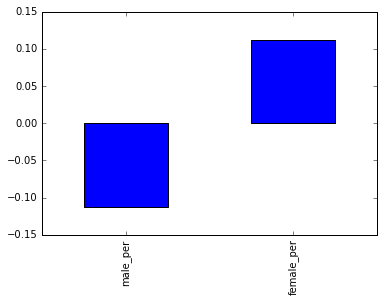

In [71]:
#now let us plot the percentage of male and female in this schools
gender_var = ['male_per','female_per']
combined.corr()['sat_score'][gender_var].plot.bar(color='blue')
plt.show()

from this, we could notice that the female_per recorded positive correlation value with the Sat_score as against the male_per with negative values with the Sat_score. Both correraltion aren't that strong

### schools with high female percentage

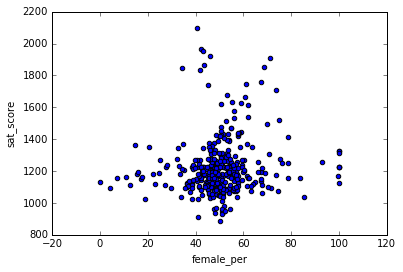

In [72]:
combined.plot.scatter('female_per', 'sat_score')
plt.show()

This simply suggests that at about 40% - 60% of schools with more females have sat_scores at about 1100-1200 sat_scores. Though, the scatter plot does not suggest any real correlation between the sat_score and the schools with a females

In [73]:
school_female = combined[(combined['female_per'] >60) & (combined['sat_score'] > 1700)] ["SCHOOL NAME"]
print(school_female)

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### schools with high male percentage

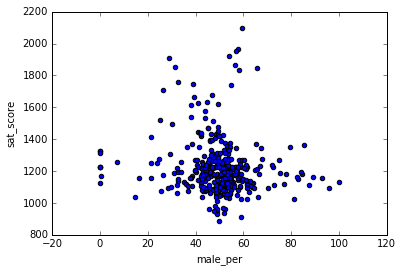

In [74]:
combined.plot.scatter('male_per', 'sat_score')
plt.show()

This simply suggests that at about 40% - 60% of schools with more males have sat_scores at about 1100-1200 sat_scores. Though, the scatter plot does not suggest any real correlation between the sat_score and the schools with a males

In [75]:
school_male = combined[(combined['male_per'] >60) & (combined['sat_score'] > 1700)] ["SCHOOL NAME"]
print(school_male)

79    HIGH SCHOOL FOR MATHEMATICS, SCIENCE AND ENGIN...
Name: SCHOOL NAME, dtype: object


Only a school has this values of having high SAT score with more males. It looks like the school is more science inclined, though there is no real correlation between the school and sat_score, this however explains why there is a high sat_score for this school. You have to score high before you get admitted

## Exploring AP score against the SAT Score

Brief caption

In the U.S, high school students take Advanced placement(AP) exams to earn college credit, and there are many AP exams for many different subjects.

In [76]:
print(combined["AP Test Takers "])

0      129.028846
1       39.000000
2       19.000000
3      129.028846
4      255.000000
5      129.028846
6      129.028846
7      129.028846
8      129.028846
9      129.028846
10      21.000000
11      99.000000
12      42.000000
13      25.000000
14     129.028846
15     129.028846
16     129.028846
17     129.028846
18     129.028846
19     129.028846
20     129.028846
21     213.000000
22      20.000000
23      78.000000
24     114.000000
25     129.028846
26     155.000000
27      86.000000
28     129.028846
29     204.000000
          ...    
333     14.000000
334     40.000000
335    129.028846
336     22.000000
337    129.028846
338    129.028846
339    129.028846
340    243.000000
341    406.000000
342    108.000000
343     51.000000
344    119.000000
345    101.000000
346    129.028846
347    129.028846
348    129.028846
349    162.000000
350     96.000000
351    194.000000
352    247.000000
353    396.000000
354    279.000000
355    129.028846
356    528.000000
357    129

In [77]:
#lets get the percentage of each student in a school that took the AP exam

combined['ap_per'] = combined['AP Test Takers '] / combined["total_enrollment"]
print(combined['ap_per']* 100)

0      30.575556
1       9.898477
2       3.177258
3      35.157724
4      15.809051
5      20.912293
6      74.154509
7      29.798810
8      37.617739
9      30.794474
10      5.072464
11     22.969838
12      9.312639
13      8.012821
14     38.401442
15     34.134615
16     26.066434
17     29.798810
18     38.864110
19     42.443699
20     52.880675
21     15.279770
22      3.984064
23     18.055556
24     19.689119
25     29.593772
26     30.571992
27     13.738019
28     30.648182
29     11.538462
         ...    
333     2.953586
334     8.456660
335    87.774725
336     5.339806
337    26.825124
338    26.066434
339    30.794474
340     8.251273
341    11.990549
342    14.285714
343     5.561614
344    12.768240
345    14.346591
346    29.324738
347    24.253543
348    31.624717
349    12.385321
350     3.611738
351     9.019061
352     9.678683
353    10.219355
354     8.603145
355    19.115385
356    47.826087
357    35.643328
358     7.755776
359    29.730149
360    19.0954

we could see that at about 16% students who took the AP TEST Takers

Now let us see the relationship or the effect of the AP TEST taker column in the SAT_SCORE



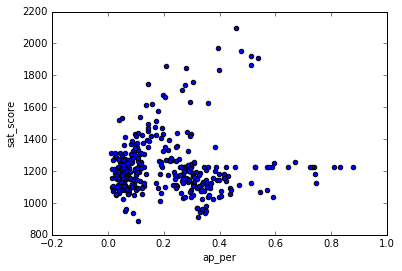

In [78]:
#using ap_per against sat_Score in a scatter plot

combined.plot.scatter('ap_per', 'sat_score')

There is somehow a relationship between those students who took an ap_test and the average sat_Score. Though this relationship is not a very strong relationship. But we can somehow see a strong correlation at some point in the correlation plot. lets see the schools that falls within this district

In [79]:
school_ap_taker = combined[(combined['ap_per'] > 0.3) & (combined['sat_score'] > 1400)]["SCHOOL NAME"]
school_ap_taker.item

<bound method Series.item of 26                         ELEANOR ROOSEVELT HIGH SCHOOL
37                                STUYVESANT HIGH SCHOOL
151                         BRONX HIGH SCHOOL OF SCIENCE
155    HIGH SCHOOL OF AMERICAN STUDIES AT LEHMAN COLLEGE
187                       BROOKLYN TECHNICAL HIGH SCHOOL
278       LEON M. GOLDSTEIN HIGH SCHOOL FOR THE SCIENCES
302                          TOWNSEND HARRIS HIGH SCHOOL
327    QUEENS HIGH SCHOOL FOR THE SCIENCES AT YORK CO...
356                  STATEN ISLAND TECHNICAL HIGH SCHOOL
Name: SCHOOL NAME, dtype: object>

### Correlation between class size and SAT score

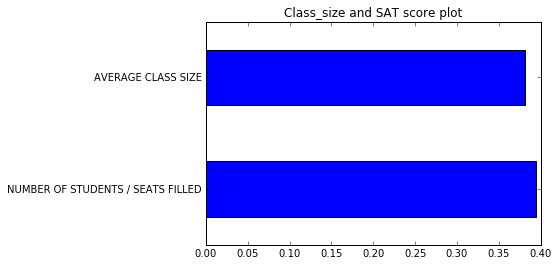

correlation of Average class size is 0.3810143308095523 
correlation of Number of students is 0.39462598144447314


In [80]:
class_size = ['NUMBER OF STUDENTS / SEATS FILLED', 'AVERAGE CLASS SIZE']
combined.corr()['sat_score'][class_size].plot.barh(color='blue')
plt.title('Class_size and SAT score plot')
plt.show()
print('correlation of Average class size is', combined.corr()['sat_score']['AVERAGE CLASS SIZE'], '\ncorrelation of Number of students is', combined.corr()['sat_score']['NUMBER OF STUDENTS / SEATS FILLED'])

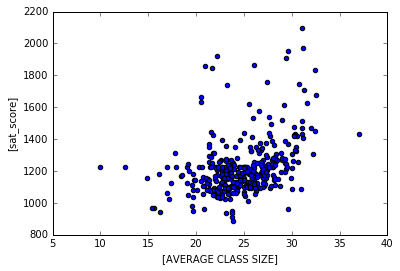

In [81]:
#getting the scatter plot for average class size
combined.plot.scatter(['AVERAGE CLASS SIZE'], ['sat_score'])

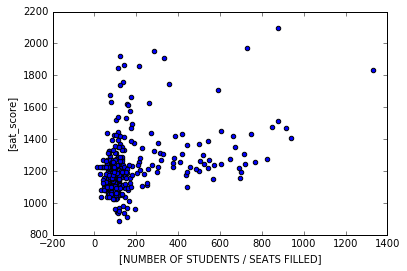

In [82]:
#getting the scatter plot for number of students / seats filled
combined.plot.scatter(['NUMBER OF STUDENTS / SEATS FILLED'], ['sat_score'])

We could see that there is a strong correlation between the average class size and the sat_score. we could see that class size actually had an impact in the sat_score. We could say that schools with average class size of 25-35 should had an effective result for the students.

### Figuring out which neighborhoods have the best schools

we could set the parameter of schools with score of 1500 as the best schools

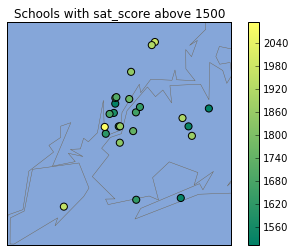

Total school with sat_scores above 1500 in the district is 24


In [83]:
best_schools = combined[combined['sat_score'] > 1500]
best_schools.is_copy = None

#We are going to map in our best schools to their respective districts
#mapping usually deals with longitude and latitude values. so lets set it up and convert it ti list

best_schools_lon = best_schools['lon'].tolist()
best_schools_lat = best_schools['lat'].tolist()

#we have gotten the list of longitude and latitude values, let us now map it.

m2 = Basemap(projection='merc',
             llcrnrlat = 40.496044, 
            urcrnrlat=40.915256, 
            llcrnrlon=-74.255735, 
            urcrnrlon=-73.700272,
            resolution='i'
            )
m2.drawmapboundary(fill_color='#85A6D9')
m2.drawcoastlines(color='#6D5F47', linewidth=.4)
m2.drawrivers(color='#6D5F47', linewidth=.4)

m2.scatter(best_schools_lon, best_schools_lat, s=50, zorder=2, latlon=True,
           c=best_schools['sat_score'], cmap='summer')
plt.title('Schools with sat_score above 1500')
plt.colorbar()
plt.show()

print('Total school with sat_scores above 1500 in the district is', best_schools['sat_score'].count())

we can see that majority of the schools with high sat_Scores are actually sitting at the Manhattan and Brooklyn district. 